# 概述

前几节我们尝试使用与房价预测相同的简单神经网络解决手写数字识别问题，但是效果并不理想。原因是手写数字识别的输入是28 × 28的像素值，输出是0-9的数字标签，而线性回归模型无法捕捉二维图像数据中蕴含的复杂信息，如 **图1** 所示。无论是牛顿第二定律任务，还是房价预测任务，输入特征和输出预测值之间的关系均可以使用“直线”刻画（使用线性方程来表达）。但手写数字识别任务的输入像素和输出数字标签之间的关系显然不是线性的，甚至这个关系复杂到我们靠人脑难以直观理解的程度。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1aef9cce4dca4a8f981b8666bec825ca372a3e7efbf64784be74881152a53014" width="600" hegiht="" ></center>
<center><br>图1：数字识别任务的输入和输入不是线性关系 </br></center>
<br></br>

因此，我们需要尝试使用其他更复杂、更强大的网络来构建手写数字识别任务，观察一下训练效果，即将“横纵式”教学法从横向展开，如 **图2** 所示。本节主要介绍两种常见的网络结构：经典的多层全连接神经网络和卷积神经网络。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/421ca2aaf93646909c1e8fd4461e1a80c0305443ef514cb9ad55e564091cd797" width="800" hegiht="" ></center>
<center><br>图2：“横纵式”教学法 — 网络结构优化 </br></center>
<br></br>

### 数据处理

在介绍网络结构前，需要先进行数据处理，代码与上一节保持一致。

In [1]:
#数据处理部分之前的代码，保持不变
import os
import random
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Linear
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import gzip
import json

# 定义数据集读取器
def load_data(mode='train'):

    # 数据文件
    datafile = './work/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28

    if mode == 'train':
        imgs = train_set[0]
        labels = train_set[1]
    elif mode == 'valid':
        imgs = val_set[0]
        labels = val_set[1]
    elif mode == 'eval':
        imgs = eval_set[0]
        labels = eval_set[1]

    imgs_length = len(imgs)

    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    index_list = list(range(imgs_length))

    # 读入数据时用到的batchsize
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

2020-03-17 10:40:37,809-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-03-17 10:40:38,209-INFO: generated new fontManager


# 经典的全连接神经网络


经典的全连接神经网络来包含四层网络：两个隐含层，输入层和输出层，将手写数字识别任务通过全连接神经网络表示，如 **图3** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/6a66c2c4674c4a19986df9e533da76dfefed8d6ccd854a8dae4cf668055e9cca" width="500" hegiht="" ></center>
<center><br>图3：手写数字识别任务的全连接神经网络结构</br></center>
<br></br>

* 输入层：将数据输入给神经网络。在该任务中，输入层的尺度为28×28的像素值。
* 隐含层：增加网络深度和复杂度，隐含层的节点数是可以调整的，节点数越多，神经网络表示能力越强，参数量也会增加。在该任务中，中间的两个隐含层为10×10的结构，通常隐含层会比输入层的尺寸小，以便对关键信息做抽象，激活函数使用常见的sigmoid函数。
* 输出层：输出网络计算结果，输出层的节点数是固定的。如果是回归问题，节点数量为需要回归的数字数量。如果是分类问题，则是分类标签的数量。在该任务中，模型的输出是回归一个数字，输出层的尺寸为1。

------
**说明：**

隐含层引入非线性激活函数sigmoid是为了增加神经网络的非线性能力。

举例来说，如果一个神经网络采用线性变换，有四个输入$x_1$~$x_4$，一个输出$y$。假设第一层的变换是$z_1=x_1-x_2$和$z_2=x_3+x_4$，第二层的变换是$y=z_1+z_2$，则将两层的变换展开后得到$y=x_1-x_2+x_3+x_4$。也就是说，无论中间累积了多少层线性变换，原始输入和最终输出之间依然是线性关系。
 
------

Sigmoid是早期神经网络模型中常见的非线性变换函数，通过如下代码，绘制出Sigmoid的函数曲线。

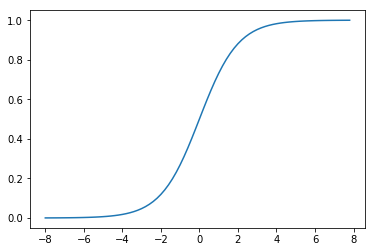

In [2]:
def sigmoid(x):
    # 直接返回sigmoid函数
    return 1. / (1. + np.exp(-x))
 
# param:起点，终点，间距
x = np.arange(-8, 8, 0.2)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

针对手写数字识别的任务，网络层的设计如下：

* 输入层的尺度为28×28，但批次计算的时候会统一加1个维度（大小为bitchsize）。
* 中间的两个隐含层为10×10的结构，激活函数使用常见的sigmoid函数。
* 与房价预测模型一样，模型的输出是回归一个数字，输出层的尺寸设置成1。

下述代码为经典全连接神经网络的实现。完成网络结构定义后，即可训练神经网络。

In [3]:
# 多层全连接神经网络实现
class MNIST(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(MNIST, self).__init__(name_scope)
        # 定义两层全连接隐含层，输出维度是10，激活函数为sigmoid
        self.fc1 = Linear(input_dim=784, output_dim=10, act='sigmoid') # 隐含层节点为10，可根据任务调整
        self.fc2 = Linear(input_dim=10, output_dim=10, act='sigmoid')
        # 定义一层全连接输出层，输出维度是1，不使用激活函数
        self.fc3 = Linear(input_dim=10, output_dim=10, act=None)
    
    # 定义网络的前向计算
    def forward(self, inputs, label=None):
        inputs = fluid.layers.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs2 = self.fc2(outputs1)
        outputs_final = self.fc3(outputs2)
        return outputs_final

In [4]:
#网络结构部分之后的代码，保持不变
with fluid.dygraph.guard():
    model = MNIST("mnist")
    model.train()
    #调用加载数据的函数，获得MNIST训练数据集
    train_loader = load_data('train')
    # 使用SGD优化器，learning_rate设置为0.01
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.01, parameter_list=model.parameters())
    # 训练5轮
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            image_data, label_data = data
            image = fluid.dygraph.to_variable(image_data)
            label = fluid.dygraph.to_variable(label_data)
            
            #前向计算的过程
            predict = model(image)
            
            #计算损失，取一个批次样本损失的平均值
            loss = fluid.layers.square_error_cost(predict, label)
            avg_loss = fluid.layers.mean(loss)
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    #保存模型参数
    fluid.save_dygraph(model.state_dict(), 'mnist')

loading mnist dataset from ./work/mnist.json.gz ......
epoch: 0, batch: 0, loss is: [27.839321]
epoch: 0, batch: 200, loss is: [8.019342]
epoch: 0, batch: 400, loss is: [6.417547]
epoch: 1, batch: 0, loss is: [6.5896306]
epoch: 1, batch: 200, loss is: [5.5006523]
epoch: 1, batch: 400, loss is: [4.270303]
epoch: 2, batch: 0, loss is: [4.0737543]
epoch: 2, batch: 200, loss is: [3.814462]
epoch: 2, batch: 400, loss is: [4.197336]
epoch: 3, batch: 0, loss is: [3.5226095]
epoch: 3, batch: 200, loss is: [2.920132]
epoch: 3, batch: 400, loss is: [3.975079]
epoch: 4, batch: 0, loss is: [2.4967484]
epoch: 4, batch: 200, loss is: [3.2558897]
epoch: 4, batch: 400, loss is: [2.3544083]


# 卷积神经网络

虽然使用经典的神经网络可以提升一定的准确率，但对于计算机视觉问题，效果最好的模型仍然是卷积神经网络。卷积神经网络针对视觉问题的特点进行了网络结构优化，更适合处理视觉问题。

卷积神经网络由多个卷积层和池化层组成，如 **图4** 所示。卷积层负责对输入进行扫描以生成更抽象的特征表示，池化层对这些特征表示进行过滤，保留最关键的特征信息。
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/ae78212c521e4814a07714a613ce1fe90832de104d7c46ed93fedb7bce18f6a0" width="700" hegiht="" ></center>
<center><br>图4：在处理计算机视觉任务中大放异彩的卷积神经网络</br></center>
<br></br>

-------
**说明：**

本节只介绍手写数字识别在卷积神经网络的实现以及它带来的效果提升。读者可以将卷积神经网络先简单的理解成是一种比经典的全连接神经网络更强大的模型即可，更详细的原理和实现在接下来的[第四章-计算机视觉-卷积神经网络基础](https://aistudio.baidu.com/aistudio/projectdetail/236887)中讲述。

------

两层卷积和池化的神经网络实现如下代码所示。

In [5]:
# 多层卷积神经网络实现
class MNIST(fluid.dygraph.Layer):
     def __init__(self, name_scope):
         super(MNIST, self).__init__(name_scope)
         
         # 定义卷积层，输出特征通道num_filters设置为20，卷积核的大小filter_size为5，卷积步长stride=1，padding=2
         # 激活函数使用relu
         self.conv1 = Conv2D(num_channels=1, num_filters=20, filter_size=5, stride=1, padding=2, act='relu')
         # 定义池化层，池化核pool_size=2，池化步长为2，选择最大池化方式
         self.pool1 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
         # 定义卷积层，输出特征通道num_filters设置为20，卷积核的大小filter_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(num_channels=20, num_filters=20, filter_size=5, stride=1, padding=2, act='relu')
         # 定义池化层，池化核pool_size=2，池化步长为2，选择最大池化方式
         self.pool2 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
         # 定义一层全连接层，输出维度是1，不使用激活函数
         self.fc = Linear(input_dim=980, output_dim=1, act=None)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = self.pool1(x)
         x = self.conv2(x)
         x = self.pool2(x)
         x = fluid.layers.reshape(x, [x.shape[0], -1])
         x = self.fc(x)
         return x

训练定义好的卷积神经网络，代码如下所示。

In [6]:
#网络结构部分之后的代码，保持不变
with fluid.dygraph.guard():
    model = MNIST("mnist")
    model.train()
    #调用加载数据的函数
    train_loader = load_data('train')
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.01, parameter_list=model.parameters())
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            image_data, label_data = data
            image = fluid.dygraph.to_variable(image_data)
            label = fluid.dygraph.to_variable(label_data)
             
            #前向计算的过程
            predict = model(image)
            
            #计算损失，取一个批次样本损失的平均值
            loss = fluid.layers.square_error_cost(predict, label)
            avg_loss = fluid.layers.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    #保存模型参数
    fluid.save_dygraph(model.state_dict(), 'mnist')

loading mnist dataset from ./work/mnist.json.gz ......
epoch: 0, batch: 0, loss is: [31.675833]
epoch: 0, batch: 200, loss is: [9.248349]
epoch: 0, batch: 400, loss is: [3.2532346]
epoch: 1, batch: 0, loss is: [2.5735705]
epoch: 1, batch: 200, loss is: [2.7086043]
epoch: 1, batch: 400, loss is: [2.351327]
epoch: 2, batch: 0, loss is: [2.2003784]
epoch: 2, batch: 200, loss is: [2.53069]
epoch: 2, batch: 400, loss is: [2.154322]
epoch: 3, batch: 0, loss is: [1.8227897]
epoch: 3, batch: 200, loss is: [1.8546791]
epoch: 3, batch: 400, loss is: [2.3879793]
epoch: 4, batch: 0, loss is: [2.6370738]
epoch: 4, batch: 200, loss is: [1.6437341]
epoch: 4, batch: 400, loss is: [1.6468849]


比较经典全连接神经网络和卷积神经网络的损失变化，可以发现卷积神经网络的损失值下降更快，且最终的损失值更小。
